**Table of contents**<a id='toc0_'></a>    
- [Plug and Play: NHS Artificial Data](#toc1_)    
  - [Goals of this notebook](#toc1_1_)    
  - [Setup](#toc1_2_)    
  - [Data Ingestion](#toc1_3_)    
  - [Basic Queries and Visualisations](#toc1_4_)    
    - [Age Distribution](#toc1_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Plug and Play: NHS Artificial Data](#toc0_)

So, you've seen the [artificial data pilot](https://digital.nhs.uk/services/artificial-data) - a tool which could help open up healthcare research on NHS datasets, greatly improve the lives of researchers, and increase patient data safety - and you'd like to take a look yourself. But where to start?

We've made this handy notebook to help you get going; querying and visualising the artificial data.

## <a id='toc1_1_'></a>[Goals of this notebook](#toc0_)
This notebook is here to give a zero-effort point of access to the [artificial datasets we've released](https://digital.nhs.uk/services/artificial-data). 

In this notebook, we're hoping to introduce the artificial data, and make it as simple as possible to go ahead and start interacting with it. 



## <a id='toc1_2_'></a>[Setup](#toc0_)

We've deliberately chosen to host this in a github Codespace. You should eb able to just open this, and start running the cells below, without having to worry about any setup. 
If, however, you want to run this code locally, you can go ahead and [clone from the repo](https://github.com/DanGoldwater1/artificial-data-plug-and-play). If you're doing that, we'd recommend that you also consult the [README](../README.md) 

#todo Make sure to link the codespace above



## <a id='toc1_3_'></a>[Data Ingestion](#toc0_)
In order to query the artificial data, we will need to:
- fetch the data
- unzip the data
- combine the `.csv` files into a single parquet file, which can be queried _a la_ SQL.

The published datasets [we can explore](https://digital.nhs.uk/services/artificial-data) are as follows:

In [ ]:

'HES_A_E_sample'
'HES_A_E_full'
'HES_Admitted_Patient_Care_sample'
'HES_Admitted_Patient_care_full'
'HES_Outpatient_sample'
'HES_Outpatient_full'

Let's start off with the A&E sample data

In [1]:
import os
import duckdb
from data_ingestion import preprocessing
db_location = 'data/main_db.db'
if os.path.exists(db_location):
    os.remove(db_location)
con = duckdb.connect(db_location)

preprocessing.download_and_transform_data(dataset_name='HES_A_E_sample',db_con=con)

Download and extraction complete.
Saved parquet file to data/HES_A_E_sample/HES_A_E_sample.parquet
Created table called HES_A_E_sample to query the data


In [1]:
%reload_ext autoreload
%autoreload 2

Next we want to use `duckdb` to connect with our data. This allows us to query the data using SQL, which mimics what you'll be doing if you proceed to working on real NHS data. 
We've also chosen to use a filetype and format which scales well. In this part of the notebook, we're only interacting with a small sample of data, and we could easily hold this in RAM as a python object. However, by choosing to convert our data to a parquet file, and to access it via duckdb, we are able to emulate the exact same practices which you would use if interacting with a much larger dataset - such as the full HES. 

## <a id='toc1_4_'></a>[Basic Queries and Visualisations](#toc0_)

We've now got data which we can query. Let's take a look at the metadata:

In [3]:
query = "PRAGMA table_info('HES_A_E_sample');"
schema_df = con.execute(query).fetchdf()

schema_df = schema_df[['name', 'type']]
display(schema_df)

,name,type
0,FYEAR,BIGINT
1,PARTYEAR,BIGINT
2,PSEUDO_HESID,VARCHAR
3,AEKEY,BIGINT
4,AEKEY_FLAG,BIGINT
...,...,...
161,NER_TREATMENT,VARCHAR
162,SITETRET,VARCHAR
163,SITEDIST,DOUBLE
164,SITEDIST_FLAG,DOUBLE


### <a id='toc1_4_1_'></a>[Age Distribution](#toc0_)
Now let's look at a single variable -- age.

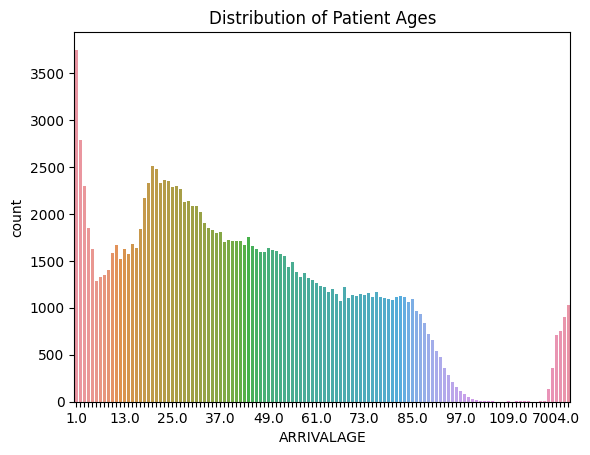

In [5]:
query_age = '''
SELECT ARRIVALAGE, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY ARRIVALAGE
ORDER BY ARRIVALAGE
'''
df1 = con.execute(query_age).fetchdf()
import matplotlib.pyplot as plt
import seaborn

plot = seaborn.barplot(data=df1, x='ARRIVALAGE', y='count')
plot.set_title('Distribution of Patient Ages')

n_x_labels_to_skip = 12 
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % n_x_labels_to_skip == 0:  # show only every nth label
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.show()


This plot demonstrates some important things about the artificial data:

- Notice that the distribution peaks around 20, and tails off after 80. This is because the column under study, `ARRIVALAGE`, will replicate the distribution in the real HES data. The values in this column will not correlate with those in any other column (unlike in the real HES data), but the distribution for this each variable alone will be statistically similar to the real thing. 
- At the high end of the $x$ axis, we can see some clustering up to the number $7004$. This looks like a straightforward error, but it is actually an artifact of how ages $< 1$ year are encoded. 

Information about the specific columns, including a description, and details about any encodings; can be found by downloading the HES Technical Specifications [stored on this page](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/hospital-episode-statistics/hospital-episode-statistics-data-dictionary). 

Text(0.5, 1.0, 'Most Common Diagnoses')

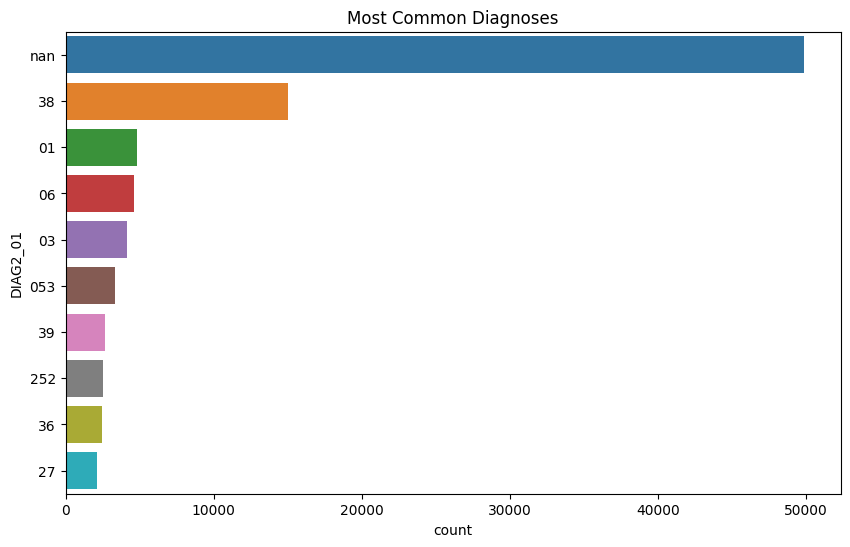

In [6]:

query2 = '''
SELECT DIAG2_01, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY DIAG2_01
ORDER BY count DESC
LIMIT 10
'''
df_diagnoses = con.execute(query2).fetchdf()
plt.figure(figsize=(10,6)) 
seaborn.barplot(data=df_diagnoses, x='count', y='DIAG2_01').set_title('Most Common Diagnoses')


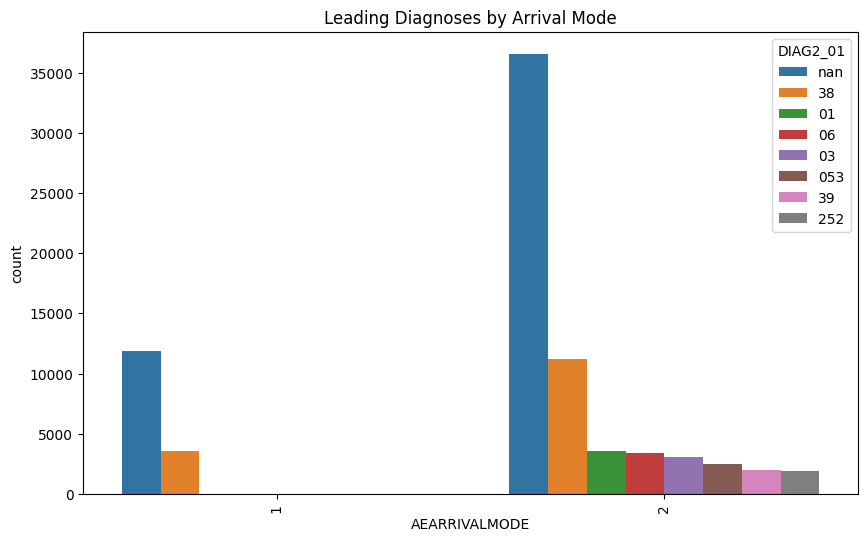

In [9]:
query = '''
SELECT AEARRIVALMODE, DIAG2_01, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY AEARRIVALMODE, DIAG2_01
ORDER BY count DESC
LIMIT 10
'''
df_diagnoses_by_arrivalmode = con.execute(query).fetchdf()

plt.figure(figsize=(10,6))
plot = seaborn.barplot(data=df_diagnoses_by_arrivalmode, x='AEARRIVALMODE', y='count', hue='DIAG2_01')
plot.set_title('Leading Diagnoses by Arrival Mode')
plt.xticks(rotation=90)
plt.show()

## Further Experiments & Full Sized Dataset
Now that we've experimented with querying the HES A&E sample dataset, we can try working with the full sized set. 

The difference between these two is that the sample set contains 10k rows, whereas the full set contains 1 million. 

This difference in scale will be important for how you process data and run queries. You can use this dataset to help test your hardware, and get an idea of how computationally expensive your analysis will be to run against real HES data. 

Note that, while the `full` artificial HES dataset which we're about to download is indeed large; it still only corresponds to *one year's* worth of HES data - so, expect to scale up your compute needs for the real thing. 

The cell below will:
1 download the full dataset
2 extract it all from a zip file, and combine it into a single parquet file
3 create a local table for you to query

Step 1 will be limited by your internet connection speed. Step 2 will be limited by your RAM and processing speed. Again; this serves as a useful test of your hardware. If the cell below takes > 10 minutes to run, don't worry. If it encounters an problem, it ought to throw an error. 




In [10]:

preprocessing.download_and_transform_data(
    dataset_name='HES_A_E_full',
    db_con=con)